<img align=center src="https://rhyme.com/assets/img/logo-dark.png"></img>
<h2 align=center>Introduction to Anomaly Detection in Time Series with Keras</h2>


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!cp '/content/drive/My Drive/Anomaly detection in Time Seires/S&P_500_Index_Data.csv' .

## Task 1: Project Overview and Import Libraries

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

%matplotlib inline

sns.set(style='whitegrid', palette='muted')
rcParams['figure.figsize'] = 14, 8
np.random.seed(1)
tf.random.set_seed(1)

print('Tensorflow version:', tf.__version__)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Tensorflow version: 2.2.0


## Task 2: Load and Inspect the S&P 500 Index Data

[Data Source](https://www.kaggle.com/pdquant/sp500-daily-19862018): S&P500 Daily Prices 1986 - 2018

In [2]:
csv_path = './S&P_500_Index_Data.csv'
df = pd.read_csv(csv_path, parse_dates=['date'])
df.head(1)

,date,close
0,1986-01-02,209.59


In [3]:
# fig = go.Figure()
# fig.add_trace(go.Scatter(x=df.date, y = df.close, mode='lines'))
# fig.update_layout(showlegend=True)
# fig.show();

## Task 3: Data Preprocessing

In [4]:
from sklearn.preprocessing import StandardScaler

train_size = int(.8 * len(df))
train, test = df.iloc[:train_size], df.iloc[train_size:]

In [91]:
scaler = StandardScaler()
scaler.fit(train[['close']])

train['close'] = scaler.transform(train[['close']])
test['close'] = scaler.transform(test[['close']])

## Task 4: Create Training and Test Splits

In [99]:
def create_sequences(X, y, time_steps = 1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:i+time_steps].values)
        ys.append(y.iloc[i+time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 30
X_train, y_train = create_sequences(train[['close']], train.close, time_steps)
X_test, y_test = create_sequences(test[['close']], test.close, time_steps)

## Task 5: Build an LSTM Autoencoder

In [100]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

model = Sequential([
    LSTM(128, input_shape=(time_steps, num_features)),
    Dropout(.2),
    RepeatVector(time_steps),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    TimeDistributed(Dense(num_features))
    ])

model.compile(loss='mae', optimizer='adam') #tf.keras.optimizers.Adadelta(.04)) #, metrics=['acc'])
# model.summary()

## Task 6: Train the Autoencoder


In [101]:
erlystpng = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')
# output = tf.keras.callbacks.LambdaCallback(lambda epoch, log: '%.3f # 0.3f'%(log['loss'], log['val_loss']))

history = model.fit(
    X_train, y_train,
    epochs = 100,
    batch_size = 32,
    validation_split = .1,
    callbacks = [erlystpng], # output],
    # validation_data = (X_test, y_test),
    shuffle = False,
    verbose = 0
)


In [108]:
# '%0.3f'%(history.history['val_loss'][-1])
# history.history['val_loss']

[0.20259498059749603,
 0.06259007006883621,
 0.05970762297511101,
 0.04155588522553444,
 0.05009562149643898,
 0.038051337003707886,
 0.08953966945409775,
 0.05330026522278786,
 0.029860304668545723,
 0.027813075110316277,
 0.05847618356347084,
 0.058929938822984695,
 0.03359304741024971]

## Task 7: Plot Metrics and Evaluate the Model

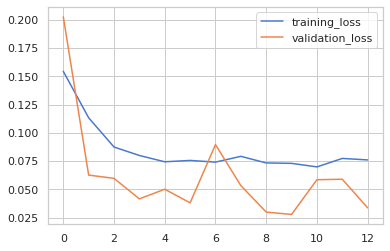

In [103]:
plt.plot(history.history['loss'], label='training_loss')
plt.plot(history.history['val_loss'], label='validation_loss')
plt.legend();

X_train_pred = model.predict(X_train)
train_mae = pd.DataFrame(np.mean(np.abs(X_train_pred - X_train), axis=1), columns=['Error'])

In [104]:
threshold = 0.65

X_test_pred = model.predict(X_test)
test_mae = np.mean(np.abs(X_test_pred - X_test), axis=1)

## Task 8: Detect Anomalies in the S&P 500 Index Data

In [105]:
test_score_df = pd.DataFrame(test[time_steps:])
test_score_df['loss'] = test_mae
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[time_steps:].close
test_score_df.head(1)

,date,close,loss,threshold,anomaly
6583,2012-02-08,1.216856,0.083059,0.65,False


In [106]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = test[time_steps:].date, y=test_score_df.loss, mode='lines',
                         name = 'Test_loss'))
fig.add_trace(go.Scatter(x = test[time_steps:].date, y=test_score_df.threshold, mode='lines',
                         name = 'Threshold'))
fig.update_layout(showlegend=True)

In [107]:
anomalies = test_score_df[test_score_df.anomaly == True]

fig = go.Figure()
fig.add_trace(go.Scatter(x = test[time_steps:].date, y = scaler.inverse_transform(test[time_steps:].close),
                         mode='lines', name = 'Close Price'))
fig.add_trace(go.Scatter(x = anomalies.date, y = scaler.inverse_transform(anomalies.close),
                         mode='markers', name = 'Anomalies'))
fig.update_layout(showlegend=True)